# "Quantitative Approach to Tactical Asset Allocation"

- Codified implementation of Med Farber's Paper with multiple extensions

- The paper takes a simple approach toward momentum on various indices

# BUY RULE
- Buy when monthly price > 10-month SMA.
# SELL RULE
- Sell and move to cash when monthly price < 10-month SMA.

Import dependencies

In [1]:
import pickle 
import numpy as np
import pandas as pd
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt

from backtest_tools import portfolio_tools as pt, risk_analysis as ra

Create utility functions

In [2]:
def get_equally_weighted_returns(returns):
    """ Function to equally weight returns across assets based on a pd.Series for a given date. This should be used 
        in conjunction with the df.apply method to do concurrent row operations.

    Args:
        returns (pd.Series): Returns across assets on given day.

    Returns:
        pd.Series: Equally weighted returns series.
    """

    return returns / len(returns.dropna())

def get_binary_positions(returns):
    """ Function to assign binary classifications of long/flat positioning based on a return series that was processed by a strategy.

    Args:
        returns (pd.Series): Long position returns series.

    Returns:
        pd.Series: Binary long/flat position assignments.
    """

    return pd.Series([0 if np.isnan(x) else 1 for i, x in returns.items()], index=returns.index)

def get_multistrategy_portfolio_weights(portfolio_positions: pd.DataFrame) -> pd.DataFrame:
    """ Function to aggregate binary positions in assets across multiple strategies (somewhat like model bagging in ML), convert them to percent
        weights, and generate a consolidated equally weighted multistrategy portfolio - useful for implementation purposes.

    Args:
        portfolio_positions (pd.DataFrame): Binary positions in assets across N_Column strategies.

    Returns:
        pd.DataFrame: Aggregate multistrategy asset portfolio weights. 
    """
    return  portfolio_positions.groupby(portfolio_positions.columns, axis=1).sum(1).apply(lambda positions: positions / positions.sum(), axis=1)

Download Asset/Index Returns Data

In [3]:
# Define investment universe of ETFs

# assets = ['SPY', 'QQQ', 'SLY', 'SPYG', 'SPYV', 'SPTM', 'MDY', 'ITOT', 'IEFA', 'SCZ', 'EEM', 'HYG', 'LQD', 'TLT', 
#           'IEF', 'BIL', 'SHY', 'DBC', 'XLRE', 'GLD', 'SLV', 'MTUM', 'DBA', 'MBB', 'AAPL', 'XLF', 'BOIL', 'UVXY', 'FXI', 'GDX', 'IWM', 'XLE']

assets = ['QQQ', 'SPY','GLD', 'DBC', 'BIL']

# Returns of opening prices
open_asset_returns = pd.DataFrame()
# Returns of close prices
close_asset_returns = pd.DataFrame()

i = 0
for ticker in assets:
    prices = yf.download(ticker, start='1980-01-01', end=dt.date.today())
    
    # Get i'th asset's returns
    close_rets = prices['Adj Close'].pct_change().dropna()
    close_rets = close_rets.rename(ticker)
    open_rets = prices['Open'].pct_change().dropna()
    open_rets = open_rets.rename(ticker)

    close_asset_returns = pd.concat([close_asset_returns, close_rets], axis=1)
    open_asset_returns = pd.concat([open_asset_returns, open_rets], axis=1)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


# Form Multistrategy Momentum Portfolio:

Example of Momentum Features

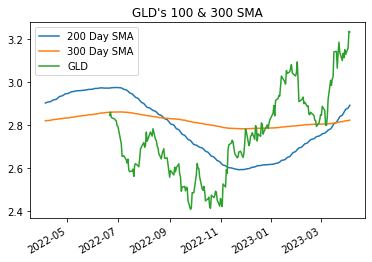

In [4]:
pt.cumulative_returns(close_asset_returns.GLD).rolling(100).mean().tail(252).plot(label='200 Day SMA', legend=True)
pt.cumulative_returns(close_asset_returns.GLD).rolling(300).mean().tail(252).plot(label='300 Day SMA', legend=True)
pt.cumulative_returns(close_asset_returns.GLD).tail(200).plot(legend=True)
plt.title("GLD's 100 & 300 SMA")
plt.show()

Define Investment Universe for Multistrategy Portfolio

In [5]:
# Diversified Portfolio
universe = ['QQQ', 'SPY','GLD', 'DBC', 'BIL']

# High Vol Portfolio
universe = ['QQQ', 'SPY']

# Get Close Returns
returns = close_asset_returns[universe]
open_returns = open_asset_returns[universe]

In [6]:
# Declare empty positions pd.DataFrame to update iteratively
multistrategy_portfolio_binary_positions = pd.DataFrame()

Hold long positions when price > 300 day & 200 day simple moving average (SMA):

,Performance Summary
Sharpe Ratio,0.585
Drift Adjusted Sharpe Ratio,2.596
CAGR,0.073
Vol,0.137
Sortino Ratio,0.723
Martin (Ulcer) Ratio,0.736
Omega Ratio,1.019
RR Ratio,1.128
Win Rate,0.555
Skew,-0.729


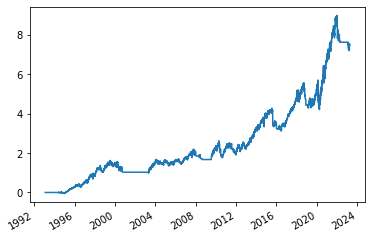

In [7]:
# ------------------------------- Old Strategies -------------------------------
# tact_strat = (open_returns.shift(-2).where(pt.cumulative_returns(returns).rolling(20).mean() > pt.cumulative_returns(returns).rolling(200).mean()))
# tact_strat = (open_returns.shift(-2).where((pt.cumulative_returns(returns) > pt.cumulative_returns(returns).ewm(span=100).mean())))
# tact_strat = (open_returns.shift(-2).where((pt.cumulative_returns(returns) > pt.cumulative_returns(returns).rolling(400).mean())))

# ------------------------------- New Strategies -------------------------------

# Generate strategy
tact_strat = (open_returns.shift(-2).where((pt.cumulative_returns(returns) > pt.cumulative_returns(returns).rolling(300).mean()) & 
                                            (pt.cumulative_returns(returns) > pt.cumulative_returns(returns).rolling(200).mean())))

# Get non-lagged positions
tact_strat_positions = (open_returns.where((pt.cumulative_returns(returns) > pt.cumulative_returns(returns).rolling(300).mean()) & 
                                            (pt.cumulative_returns(returns) > pt.cumulative_returns(returns).rolling(200).mean())))

# Get binary positions & update multistrategy positions pd.DataFrame
tact_strat_positions = tact_strat_positions.apply(lambda x: get_binary_positions(x))
multistrategy_portfolio_binary_positions = pd.concat([multistrategy_portfolio_binary_positions, tact_strat_positions], axis=1)

# Equally weight returns on every day
tact_strat = tact_strat.apply(lambda x: get_equally_weighted_returns(x), axis=1)
# tact_strat = tact_strat*(1/6) - use this if we want to equal weight portfolio at all times, regardless of it positions exist
tact_strat = tact_strat.sum(1)
tact_strat_cum_rets = pt.cumulative_returns(tact_strat)
tact_strat_cum_rets.plot()
pt.performance_summary(tact_strat)

Hold long positions when 100 day SMA > 400 day SMA:

,Performance Summary
Sharpe Ratio,0.662
Drift Adjusted Sharpe Ratio,1.666
CAGR,0.099
Vol,0.162
Sortino Ratio,0.817
Martin (Ulcer) Ratio,1.094
Omega Ratio,1.051
RR Ratio,1.145
Win Rate,0.558
Skew,-0.411


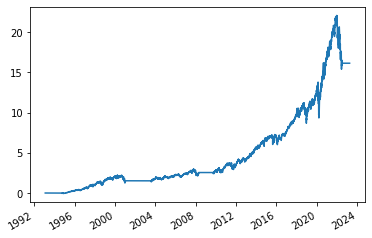

In [8]:
# Generate strategy
tact_strat_2 = (open_returns.shift(-2).where(pt.cumulative_returns(returns).rolling(100).mean() > pt.cumulative_returns(returns).rolling(400).mean()))

# Get non-lagged positions
tact_strat_2_positions = (open_returns.where(pt.cumulative_returns(returns).rolling(100).mean() > pt.cumulative_returns(returns).rolling(400).mean()))

# Get binary positions & update multistrategy positions pd.DataFrame
tact_strat_2_positions = tact_strat_2_positions.apply(lambda x: get_binary_positions(x))
multistrategy_portfolio_binary_positions = pd.concat([multistrategy_portfolio_binary_positions, tact_strat_2_positions], axis=1)

# Equally weight returns on every day
tact_strat_2 = tact_strat_2.apply(lambda x: get_equally_weighted_returns(x), axis=1)
tact_strat_2 = tact_strat_2.sum(1)

tact_strat_2_cum_rets = pt.cumulative_returns(tact_strat_2)
tact_strat_2_cum_rets.plot()
pt.performance_summary(tact_strat_2)

Hold long positions when price is above 300 SMA:

,Performance Summary
Sharpe Ratio,0.599
Drift Adjusted Sharpe Ratio,3.291
CAGR,0.080
Vol,0.147
Sortino Ratio,0.738
Martin (Ulcer) Ratio,0.824
Omega Ratio,1.028
RR Ratio,1.128
Win Rate,0.555
Skew,-0.603


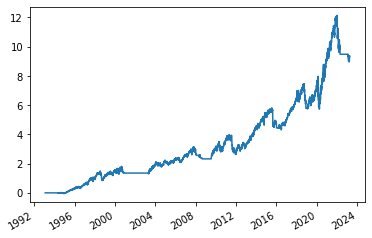

In [9]:
# Generate strategy
tact_strat_3 = (open_returns.shift(-2).where((pt.cumulative_returns(returns) > pt.cumulative_returns(returns).rolling(300).mean())))

# Get non-lagged positions
tact_strat_3_positions = (open_returns.where((pt.cumulative_returns(returns) > pt.cumulative_returns(returns).rolling(300).mean())))

# Get binary positions & update multistrategy positions pd.DataFrame
tact_strat_3_positions = tact_strat_3_positions.apply(lambda x: get_binary_positions(x))
multistrategy_portfolio_binary_positions = pd.concat([multistrategy_portfolio_binary_positions, tact_strat_3_positions], axis=1)

# Equally weight returns on every day
tact_strat_3 = tact_strat_3.apply(lambda x: get_equally_weighted_returns(x), axis=1)
tact_strat_3 = tact_strat_3.sum(1)
tact_strat_3_cum_rets = pt.cumulative_returns(tact_strat_3)
tact_strat_3_cum_rets.plot()
pt.performance_summary(tact_strat_3)

Hold long positions when 100 day SMA > 300 day SMA:

,Performance Summary
Sharpe Ratio,0.662
Drift Adjusted Sharpe Ratio,1.746
CAGR,0.098
Vol,0.161
Sortino Ratio,0.819
Martin (Ulcer) Ratio,0.899
Omega Ratio,1.050
RR Ratio,1.144
Win Rate,0.557
Skew,-0.492


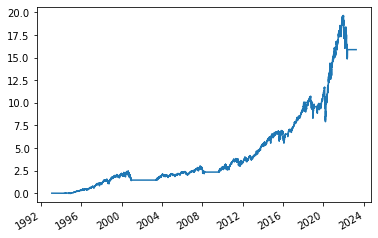

In [10]:
# Generate strategy
tact_strat_4 = (open_returns.shift(-2).where(pt.cumulative_returns(returns).rolling(100).mean() > pt.cumulative_returns(returns).rolling(300).mean()))

# Get non-lagged positions
tact_strat_4_positions = (open_returns.where(pt.cumulative_returns(returns).rolling(100).mean() > pt.cumulative_returns(returns).rolling(300).mean()))

# Get binary positions & update multistrategy positions pd.DataFrame
tact_strat_4_positions = tact_strat_4_positions.apply(lambda x: get_binary_positions(x))
multistrategy_portfolio_binary_positions = pd.concat([multistrategy_portfolio_binary_positions, tact_strat_4_positions], axis=1)

# Equally weight returns on every day
tact_strat_4 = tact_strat_4.apply(lambda x: get_equally_weighted_returns(x), axis=1)
tact_strat_4 = tact_strat_4.sum(1)
tact_strat_4_cum_rets = pt.cumulative_returns(tact_strat_4)
tact_strat_4_cum_rets.plot()
pt.performance_summary(tact_strat_4)

# Backtest Equally Weighted Aggregate Portfolio of Momentum Strategies:

Get aggregate portfolio weights for each asset - useful for implementation purposes

In [11]:
portfolio_weights = get_multistrategy_portfolio_weights(multistrategy_portfolio_binary_positions)
portfolio_weights.index.name = 'Trailing 5-Day Portfolio Weights:'
portfolio_weights.tail().fillna(0).round(3)

,QQQ,SPY
Trailing 5-Day Portfolio Weights:,,
2023-03-30,0.5,0.5
2023-03-31,0.5,0.5
2023-04-03,0.5,0.5
2023-04-04,0.5,0.5
2023-04-05,0.5,0.5


Pre-2013 Performance

,Performance Summary
Sharpe Ratio,0.656
Drift Adjusted Sharpe Ratio,8.187
CAGR,0.089
Vol,0.147
Sortino Ratio,0.850
Martin (Ulcer) Ratio,0.953
Omega Ratio,1.037
RR Ratio,1.132
Win Rate,0.548
Skew,-0.292


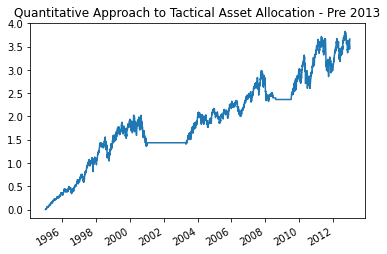

In [12]:
# Aggregate strategy portfolio
combined_tact_strat = pd.concat([tact_strat, tact_strat_2, tact_strat_3, tact_strat_4], axis=1)*.25
combined_tact_strat = combined_tact_strat.loc['1995':]

# Get correlation matrix across strategies
corr_matrix = combined_tact_strat.corr()

# Analyze performance pre-2013
combined_tact_strat_pre_2013 = combined_tact_strat.sum(1).loc[:'2012']
pt.cumulative_returns(combined_tact_strat_pre_2013).plot(title='Quantitative Approach to Tactical Asset Allocation - Pre 2013')
pt.performance_summary(combined_tact_strat_pre_2013)

Post-2013 Performance

,Performance Summary
Sharpe Ratio,0.757
Drift Adjusted Sharpe Ratio,8.836
CAGR,0.109
Vol,0.152
Sortino Ratio,0.864
Martin (Ulcer) Ratio,1.308
Omega Ratio,1.061
RR Ratio,1.155
Win Rate,0.572
Skew,-1.192


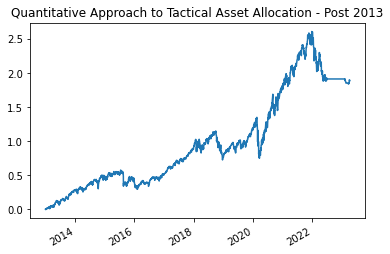

In [13]:
# Analyze performance post-2013
combined_tact_strat_post_2013 = combined_tact_strat.sum(1).loc['2013':]
pt.cumulative_returns(combined_tact_strat_post_2013).plot(title='Quantitative Approach to Tactical Asset Allocation - Post 2013')
pt.performance_summary(combined_tact_strat_post_2013)

Full Sample Performance

,Performance Summary
Sharpe Ratio,0.693
Drift Adjusted Sharpe Ratio,2.291
CAGR,0.096
Vol,0.149
Sortino Ratio,0.857
Martin (Ulcer) Ratio,1.068
Omega Ratio,1.046
RR Ratio,1.140
Win Rate,0.557
Skew,-0.638


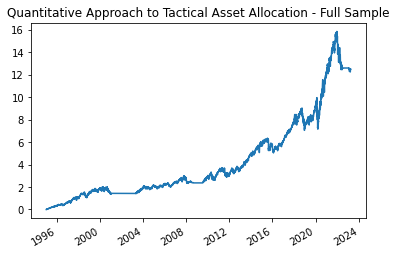

In [14]:
# Analyze full sample performance
combined_tact_strat = combined_tact_strat.sum(1)
combined_tact_strat.name = 'Multistrategy Momentum Portfolio'
((1+combined_tact_strat).cumprod()-1).plot(title='Quantitative Approach to Tactical Asset Allocation - Full Sample')
pt.performance_summary(combined_tact_strat)

# Robustness Tests

Monte Carlo Bootstrap

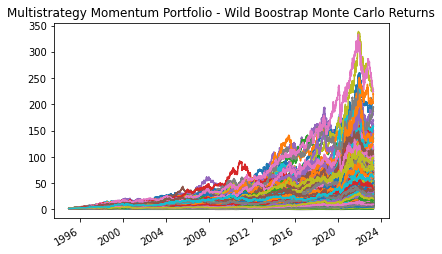

,Bootstrap Summary Statistics,Historical Summary Statistics
Mean,0.0004,0.0004
STD,0.0133,0.0094
Skew,-0.2337,-0.6384
Kurtosis,12.3480,11.2311
5th Moment,-0.0000,-0.0000
VaR - 99% CI,-0.0368,NaN
CVaR - 99% CI,-0.0512,NaN
EV of Cumulative Returns,11.6167,NaN
Pct. of Negative Cumulative Returns,0.0030,NaN
STD of Mean,0.0001,NaN


In [15]:
ra.robustness_test(combined_tact_strat)

In [16]:
# Print correlation matrix - strategies are correlated, but not too highly correlated where they won't be additive
corr_matrix

,0,1,2,3
0,1.0000,0.7925,0.9300,0.8197
1,0.7925,1.0000,0.8478,0.9571
2,0.9300,0.8478,1.0000,0.8865
3,0.8197,0.9571,0.8865,1.0000


# Backtest Benchmark Returns

Core Conclusion:

- Momentum strategy beats S&P 500 in the long run in terms of drawdowns, absolute return, and risk-adjusted return

In [17]:
benchmark_returns = pt.scale_vol(close_asset_returns.SPY.dropna(), target_vol=0.1490).loc['1995':]
# benchmark_returns = raw_asset_returns.SPY.dropna()

Pre-2013 Performance

,Performance Summary
Sharpe Ratio,0.4990
Drift Adjusted Sharpe Ratio,1.7760
CAGR,0.0690
Vol,0.1610
Sortino Ratio,0.6620
Martin (Ulcer) Ratio,0.5450
Omega Ratio,1.0150
RR Ratio,1.0970
Win Rate,0.5410
Skew,0.1250


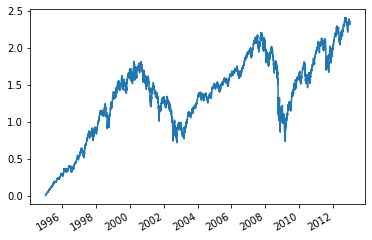

In [18]:
pt.cumulative_returns(benchmark_returns.loc[:'2012']).plot()
pt.performance_summary(benchmark_returns.loc[:'2012'])

Post-2013 Performance

,Performance Summary
Sharpe Ratio,0.7850
Drift Adjusted Sharpe Ratio,14.7960
CAGR,0.1010
Vol,0.1370
Sortino Ratio,0.9440
Martin (Ulcer) Ratio,2.0120
Omega Ratio,1.0580
RR Ratio,1.1630
Win Rate,0.5500
Skew,-0.5650


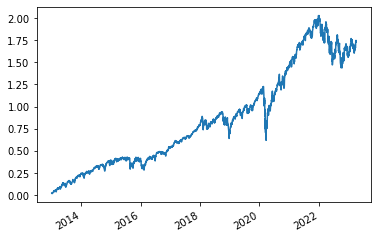

In [19]:
pt.cumulative_returns(benchmark_returns.loc['2013':]).plot()
pt.performance_summary(benchmark_returns.loc['2013':])

Full Sample Performance

,Performance Summary
Sharpe Ratio,0.5900
Drift Adjusted Sharpe Ratio,2.0720
CAGR,0.0810
Vol,0.1530
Sortino Ratio,0.7570
Martin (Ulcer) Ratio,0.7390
Omega Ratio,1.0280
RR Ratio,1.1180
Win Rate,0.5440
Skew,-0.0570


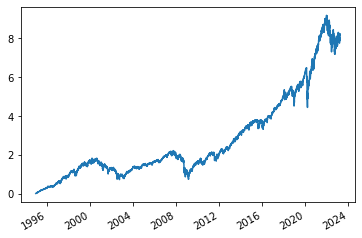

: 

In [20]:
pt.cumulative_returns(benchmark_returns).plot()
pt.performance_summary(benchmark_returns)